In [292]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import pandas as pd
import plotly.express as px
import os
import pickle
import sys
import plotly.offline as pyo
from pathlib import Path

In [293]:
ROOT_DIR = os.path.dirname(
os.path.dirname(
    str(Path(os.path.abspath('')).absolute())))

sys.path.append(os.path.join(ROOT_DIR, "code"))
from tools.data_loader import TestSet, TestSplit, data_loader
from tools.transform import magnitude_transform
from tools.utils import get_structure_encoding, StructureEncoding


In [294]:
PLOT_DIR  = os.path.join(
    str(Path(os.path.abspath('')).parent.parent.absolute()), "plots/decision_boundaries/")

# Load Model

In [295]:
TARGET_NAME = "delta_E_magnitude/"
ENCODING_NAME = "atomic/"
MODEL_NAME = "random_forest_model.pkl"

In [296]:
MODELS_DIR = os.path.join(
    str(Path(os.path.abspath('')).parent.parent.absolute()), "models/", TARGET_NAME, ENCODING_NAME
)

In [297]:
with open(MODELS_DIR + MODEL_NAME, 'rb') as file:
    model = pickle.load(file)

# Load Data Sets

In [298]:
X_TRAIN_NAME = "X_train.csv"
y_TRAIN_NAME = "y_train.csv"

In [299]:
X_train = pd.read_csv(MODELS_DIR + "/datasets/" + X_TRAIN_NAME, index_col=0)
y_train = pd.read_csv(MODELS_DIR + "/datasets/" + y_TRAIN_NAME, index_col=0)

In [300]:
X_TEST_NAME = "X_Parameter gen..csv"
y_TEST_NAME = "y_Parameter gen..csv"

In [301]:
X_test = pd.read_csv(MODELS_DIR + "/datasets/" + X_TEST_NAME, index_col=0)
y_test = pd.read_csv(MODELS_DIR + "/datasets/" + y_TEST_NAME, index_col=0)

In [302]:
X_test.describe()

,ecutrho,k_density,ecutwfc,Ag,Al,Ar,As,Au,B,Ba,...,Tl,Tm,V,W,Xe,Y,Yb,Zn,Zr,total_atoms
count,53958.000000,53958.000000,53958.000000,53958.000000,53958.000000,53958.0,53958.000000,53958.000000,53958.000000,53958.000000,...,53958.000000,53958.000000,53958.000000,53958.00000,53958.0,53958.000000,53958.000000,53958.000000,53958.000000,53958.000000
mean,244.475333,5.904963,57.110438,0.018894,0.015438,0.0,0.012575,0.018746,0.009229,0.007144,...,0.015484,0.010434,0.013436,0.00669,0.0,0.016429,0.014205,0.020451,0.019228,2.010675
std,89.627699,2.826279,23.751455,0.095343,0.086491,0.0,0.078290,0.094983,0.067302,0.059340,...,0.086617,0.071472,0.080856,0.05745,0.0,0.089134,0.083073,0.099033,0.096148,0.145727
min,100.000000,2.000000,20.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000
25%,180.000000,4.000000,35.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000
50%,260.000000,6.000000,55.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000
75%,340.000000,8.000000,75.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000
max,380.000000,10.000000,100.000000,0.500000,0.500000,0.0,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.50000,0.0,0.500000,0.500000,0.500000,0.500000,4.000000


# Choose a structure

In [303]:
structure_key = 'NaCl'

In [304]:
def filter_data(X, y, structure_key):
    elt1 = structure_key[0:2]
    elt2 = structure_key[2:]
    print(elt1)
    print(elt2)
    
    mask = (X[elt1]*X[elt2]).to_numpy().nonzero()[0]
    print(f"Size of subset for {structure_key}: ", len(mask))
    
    return X.iloc[mask], y.iloc[mask]

In [305]:
X_train, y_train = filter_data(X_train, y_train, structure_key)
X_test, y_test = filter_data(X_test, y_test, structure_key)

Na
Cl
Size of subset for NaCl:  569
Na
Cl
Size of subset for NaCl:  59


In [306]:
y_train_magnitude = magnitude_transform(y_train)
y_test_magnitude = magnitude_transform(y_test)

# Initialize grid

In [307]:
h = 0.1
x_min_train, x_max_train = X_train['ecutwfc'].min() - 1, X_train['ecutwfc'].max() + 1
y_min_train, y_max_train = X_train['k_density'].min() - 1, X_train['k_density'].max() + 1


x_min_test, x_max_test = X_test['ecutwfc'].min() - 1, X_test['ecutwfc'].max() + 1
y_min_test, y_max_test = X_test['k_density'].min() - 1, X_test['k_density'].max() + 1

x_max = max(x_max_train, x_max_test)
y_max = max(y_max_train, y_max_test)
x_min = min(x_min_train, x_min_test)
y_min = min(y_min_train, y_min_test)


xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


# Get decision boundary for a given structure structure

In [308]:
structure_encoding = get_structure_encoding(structure_key, StructureEncoding.ATOMIC)

In [309]:
def assemble_features(xx, yy):
    return np.vstack((4*xx.T, yy.T, xx.T))


def magnitude_prediction(xx, yy, estimator, structure_encoding):
    structure_block = np.stack([structure_encoding for _ in range(len(xx))])
    input = np.vstack((assemble_features(xx, yy), structure_block.T)).T
    #input = pd.DataFrame(input.T, columns=X_train.columns)
    return estimator.predict(input)



(1.0, 10.90000000000001)

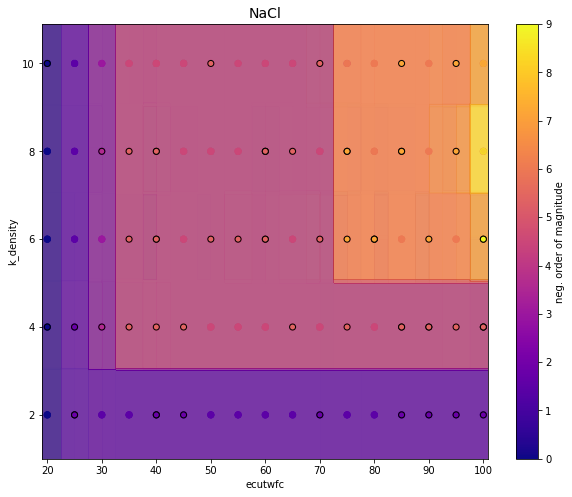

In [310]:
cm = plt.cm.plasma
norm = mpl.colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 1, figsize=(10,8))

estimator_alpha = 1.0 / len(model.estimators_)
for estimator in model.estimators_:
    predictor = lambda xx, yy : magnitude_prediction(xx, yy, estimator, structure_encoding)
    
    Z = predictor(xx.ravel(), yy.ravel())
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cm)
    
ax.scatter(X_train['ecutwfc'], X_train['k_density'], c=y_train_magnitude, alpha=0.5, cmap=cm)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], c=y_test_magnitude, edgecolors="k", cmap=cm)

plt.title(structure_key, fontsize=14)
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
fig.colorbar(sm, label="neg. order of magnitude")
ax.set_xlabel("ecutwfc")
ax.set_ylabel("k_density")
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())